# Create Submission File

## Imports and get data

In [ ]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from HelpFunctions.date_and_time import most_recent_thursday, split_time

from DAX.HelpFunctions.get_dax_data import get_dax_data
from DAX.Models import baseline as dax_bl
from DAX.Models import garch11 as dax_garch

from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from Energy.Models import baseline as en_bl
from Energy.Models import Model4_population as en_m4_pop
from datetime import datetime
import pytz

# import importlib
# importlib.reload(Energy.Models)

# import importlib
# importlib.reload(Energy.Models)

### DAX: Get and prepare Data
Use tuesday as last datapoint

In [ ]:
# Insert Date of Wednesday (forecast-day) here. The current day has to be wednesday!!
start_date = datetime(2024, 1, 31, 18, 0, 0)
assert start_date.weekday() == 2

In [ ]:
df_dax = get_dax_data()
# pretend_start_date = date(2023, 11, 22, 11, 00, 0, tzinfo=pytz.timezone('Europe/Berlin'))

df_dax = df_dax[df_dax.index.date <= start_date.date()]

In [ ]:
df_dax.tail()

### Energy: Get and prepare Data

In [5]:
from Energy.HelpFunctions.get_energy_data import fetch_energy_data
fetch_energy_data()

100%|██████████| 267/267 [01:16<00:00,  3.48it/s]


<Axes: xlabel='date_time'>

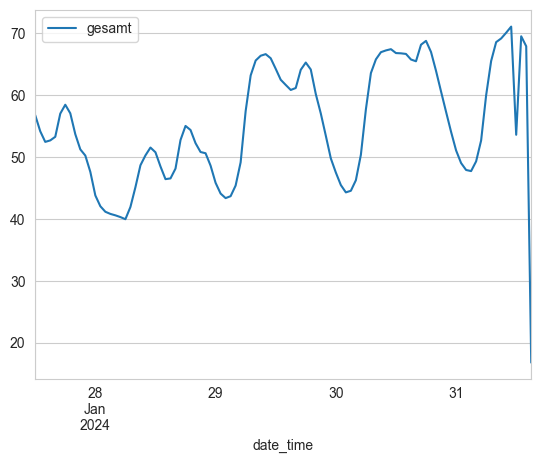

In [12]:
df_en = get_energy_data(force_return=True)
df_en = prepare_data(df_en)
df_en.tail(100).plot()

<Axes: xlabel='date_time'>

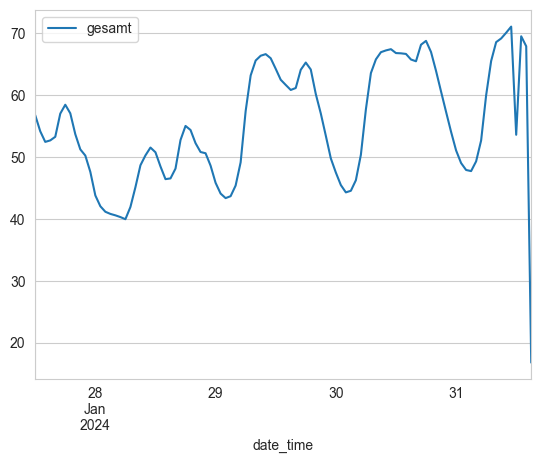

In [13]:
df_en = df_en.loc[df_en.index <= start_date]

In [21]:
df_en = df_en[:-6]

In [22]:
df_en.tail(20)

,gesamt
date_time,
2024-01-30 14:00:00,66.64400
2024-01-30 15:00:00,65.74350
2024-01-30 16:00:00,65.45900
2024-01-30 17:00:00,68.13225
2024-01-30 18:00:00,68.75525
2024-01-30 19:00:00,66.95950
2024-01-30 20:00:00,63.90750
2024-01-30 21:00:00,60.58025
2024-01-30 22:00:00,57.29900


In [ ]:
# Check if still required next week ...
# df_en.loc['2024-01-17 16:00:00', 'gesamt'] = (df_en.loc['2024-01-17 15:00:00', 'gesamt'] +df_en.loc['2024-01-17 17:00:00', 'gesamt'])/2
# df_en.tail()

## Run models for the data

### DAX

In [26]:
from DAX.Models import arma_garch_11 as ag
from DAX.Models import baseline as bl

import importlib
importlib.reload(ag)
importlib.reload(bl)


# dax_bl.baseline(df_dax)
# forecast_dax = dax_garch.garch11(df_dax)
forecast_dax = mix_models([ag.garch11_norm_1y, bl.baseline_1y], [1,0.5], df_dax, 'DAX')
forecast_dax


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-01,DAX,1 day,-1.431284,-0.418136,0.015949,0.477029,1.410996
1,2024-02-02,DAX,2 day,-1.836779,-0.575534,0.012975,0.624666,1.877701
2,2024-02-05,DAX,5 day,-2.520480,-0.775994,0.041453,0.873095,2.476310
3,2024-02-06,DAX,6 day,-2.930316,-0.910925,0.061370,1.047922,2.960356
4,2024-02-07,DAX,7 day,-3.200533,-0.974782,0.082279,1.184686,3.212773


### Energy  

In [30]:
from Energy.Models import mstl
from Energy.Models.baseline import baseline
from HelpFunctions.mix_models import mix_models_per_horizon
from Energy.Models.Model4_sunhours import model4_sunhours
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_population import model4_population
from Energy.Models import Model5

# en_bl.baseline(df_en, LAST_IDX=-1, offset_horizons=11)

import importlib
importlib.reload(Model5)
importlib.reload(mstl)

weights_m5_bl_m4_x = [1,1]
functions_m5_bl_m4_x = [mstl.mstl, Model5.model5]




# forecast_en = en_m4_pop.model4_population(df_en, offset_horizons=15)
forecast_en = mix_models(functions_m5_bl_m4_x, weights_m5_bl_m4_x, df_en, target="energy", offset_horizons=14)
forecast_en

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-02 12:00:00,energy,36 hour,55.172147,61.659491,65.163901,67.614405,72.327468
1,2024-02-02 16:00:00,energy,40 hour,53.491346,59.255849,62.455421,65.050200,69.775268
2,2024-02-02 20:00:00,energy,44 hour,51.507866,56.589764,59.279514,61.763757,66.588771
3,2024-02-03 12:00:00,energy,60 hour,45.984918,52.458226,55.496642,57.743740,62.058170
4,2024-02-03 16:00:00,energy,64 hour,44.494820,50.245287,52.978865,55.370238,59.696672
5,2024-02-03 20:00:00,energy,68 hour,43.644973,48.712835,50.936591,53.217429,57.643809


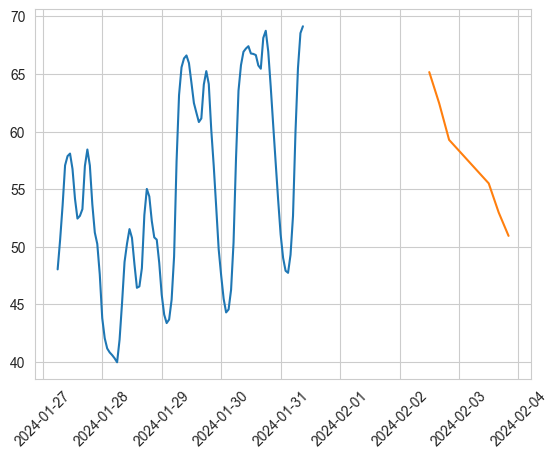

In [65]:
plot_df = forecast_en.copy() \
    .set_index('forecast_date')['q0.5']
plt.plot(df_en[-100:])
plt.plot(plot_df)
plt.xticks(rotation=45)
plt.show()

### Infections

In [46]:
forecast_infections = {
    'forecast_date': [start_date.strftime('%Y-%m-%d')] * 5,
    'target': ['infections'] * 5,
    'horizon': ['0 week', '1 week', '2 week', '3 week', '4 week'],
    # 'q0.025': ['NA'] * 5,
    # 'q0.25': ['NA'] * 5,
    # 'q0.5': ['NA'] * 5,
    # 'q0.75': ['NA'] * 5,
    # 'q0.975': ['NA'] * 5,
    'q0.025': [np.nan] * 5,
    'q0.25': [np.nan] * 5,
    'q0.5': [np.nan] * 5,
    'q0.75': [np.nan] * 5,
    'q0.975': [np.nan] * 5
}

forecast_infections = pd.DataFrame(forecast_infections)

In [47]:
forecast_infections

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,infections,0 week,NaN,NaN,NaN,NaN,NaN
1,2024-01-31,infections,1 week,NaN,NaN,NaN,NaN,NaN
2,2024-01-31,infections,2 week,NaN,NaN,NaN,NaN,NaN
3,2024-01-31,infections,3 week,NaN,NaN,NaN,NaN,NaN
4,2024-01-31,infections,4 week,NaN,NaN,NaN,NaN,NaN


## Merge results

Check results: Are they valid, forecast_date is right? The last entry might be cut off

In [48]:
forecasts = pd.concat([forecast_dax,forecast_en, forecast_infections]).reset_index().drop(columns=['index'])
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-02-01,DAX,1 day,-1.431284,-0.418136,0.015949,0.477029,1.410996
1,2024-02-02,DAX,2 day,-1.836779,-0.575534,0.012975,0.624666,1.877701
2,2024-02-05,DAX,5 day,-2.520480,-0.775994,0.041453,0.873095,2.476310
3,2024-02-06,DAX,6 day,-2.930316,-0.910925,0.061370,1.047922,2.960356
4,2024-02-07,DAX,7 day,-3.200533,-0.974782,0.082279,1.184686,3.212773
5,2024-02-02 12:00:00,energy,36 hour,55.172147,61.659491,65.163901,67.614405,72.327468
6,2024-02-02 16:00:00,energy,40 hour,53.491346,59.255849,62.455421,65.050200,69.775268
7,2024-02-02 20:00:00,energy,44 hour,51.507866,56.589764,59.279514,61.763757,66.588771
8,2024-02-03 12:00:00,energy,60 hour,45.984918,52.458226,55.496642,57.743740,62.058170
9,2024-02-03 16:00:00,energy,64 hour,44.494820,50.245287,52.978865,55.370238,59.696672


If everything seems good: Override forecast_date

In [49]:
forecasts['forecast_date'] = [start_date.strftime('%Y-%m-%d') for _ in range(len(forecasts))]

In [50]:
forecasts

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2024-01-31,DAX,1 day,-1.431284,-0.418136,0.015949,0.477029,1.410996
1,2024-01-31,DAX,2 day,-1.836779,-0.575534,0.012975,0.624666,1.877701
2,2024-01-31,DAX,5 day,-2.520480,-0.775994,0.041453,0.873095,2.476310
3,2024-01-31,DAX,6 day,-2.930316,-0.910925,0.061370,1.047922,2.960356
4,2024-01-31,DAX,7 day,-3.200533,-0.974782,0.082279,1.184686,3.212773
5,2024-01-31,energy,36 hour,55.172147,61.659491,65.163901,67.614405,72.327468
6,2024-01-31,energy,40 hour,53.491346,59.255849,62.455421,65.050200,69.775268
7,2024-01-31,energy,44 hour,51.507866,56.589764,59.279514,61.763757,66.588771
8,2024-01-31,energy,60 hour,45.984918,52.458226,55.496642,57.743740,62.058170
9,2024-01-31,energy,64 hour,44.494820,50.245287,52.978865,55.370238,59.696672


### Check df & Save csv-File

In [51]:
from HelpFunctions.check_submission import check_submission_df

check_submission_df(forecasts)
forecasts.to_csv(f'./Abgaben/{start_date.strftime("%Y%m%d")}_JakePeralta.csv', na_rep='NA', index=False)

Start checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- infections -- is your NaN-target. Please DOUBLECHECK if this is correct.
---------------------------
Looks good!


/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check_submission.py:175: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  diffs[0] = 0
/Users/elias/Desktop/PTSFC/HelpFunctions/check